# Natural Language Processing for Healthcare M&A Communication Analysis: Predicting Deal Success Through Linguistic Pattern Recognition
Maksim Kocheshkov
DSE

## 1. EDA

### 1.1. Preprocessing

In [6]:
import pandas as pd
import numpy as np
import os
import re
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up the environment
DATA_PATH = 'transcripts'
FINANCIALS_FILE = 'FINAL_merged_transactions_and_financials.csv'

# Load transaction metadata
transactions_df = pd.read_csv(FINANCIALS_FILE)

# Create a new column with the expected transcript filename
transactions_df['transcript_filename'] = transactions_df['Corresponding transcript'] + '.txt'

# Create data loader
def load_ma_documents(data_path):
    """
    Load all M&A announcement texts and create a structured dataset
    """
    documents = []

    for filename in os.listdir(data_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(data_path, filename)

            # Read the document
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()

            # Extract metadata from filename or match
            doc_info = {
                'filename': filename,
                'text': text,
                'text_length': len(text),
                'word_count': len(text.split()),
                'sentence_count': len(re.split(r'[.!?]+', text))
            }

            documents.append(doc_info)

    return pd.DataFrame(documents)

# Load documents
docs_df = load_ma_documents(DATA_PATH)

# Merge with transaction metadata
merged_df = pd.merge(
    docs_df,
    transactions_df,
    left_on='filename',
    right_on='transcript_filename',
    how='inner'
)

print(f"Loaded {len(merged_df)} documents with metadata")
print(f"Transaction types: {merged_df['Transaction Type'].value_counts()}")
print(f"Year distribution: {merged_df['Year'].value_counts().sort_index()}")

Loaded 193 documents with metadata
Transaction types: Transaction Type
Acquisition                         94
Merger                              21
Asset Acquisition                   16
Licensing                           12
Reverse Merger                      10
SPAC Merger                          6
Joint Venture                        5
Divestiture                          4
Collaboration                        3
Spin-off                             2
Asset Reacquisition                  2
Re-acquisition                       2
Strategic Partnership                2
Strategic Financing                  2
Royalty Acquisition                  2
Reverse Acquisition                  1
Strategic Investment                 1
Strategic Arrangement                1
Merger Update                        1
Dual Acquisition                     1
Asset Licensing                      1
Merger + PIPE                        1
Acquisition Close                    1
Reverse Merger/Asset Acquisition

### 1.2. Basic text preprocessing with BERT tokenization

In [7]:
import nltk
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import defaultdict
import re

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load spaCy model for advanced NLP
nlp = spacy.load('en_core_web_sm')

class MATextPreprocessor:
    """
    Specialized preprocessor for M&A announcements with chunking strategy.

    Uses chunking approach to handle long documents while maintaining BERT compatibility.
    BERT has a hard limit of 512 tokens due to positional encoding constraints, so
    documents are split into overlapping chunks to preserve all content while ensuring
    compatibility with transformer-based analysis in later phases.

    Methodology Choice: Chunking over truncation preserves all document information
    while maintaining compatibility with BERT's architectural constraints.
    """
    def __init__(self, max_length=512, overlap=50):
        # Use BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length
        self.overlap = overlap  # Tokens to overlap between chunks for context continuity

        # M&A-specific stopwords to preserve
        self.preserve_words = {
            'synergy', 'acquisition', 'merger', 'strategic', 'accretive',
            'dilutive', 'premium', 'regulatory', 'antitrust', 'integration'
        }

        # Financial entities to extract - captures quantitative M&A metrics
        self.financial_patterns = {
            'deal_value': r'\$[\d,]+(?:\.\d+)?[BMK]?(?:illion|illion)?',
            'percentage': r'\d+(?:\.\d+)?%',
            'multiple': r'\d+(?:\.\d+)?x',
            'per_share': r'\$\d+(?:\.\d+)?\s*per\s*share'
        }

    def extract_financial_entities(self, text):
        """Extract financial metrics from text"""
        entities = defaultdict(list)

        for entity_type, pattern in self.financial_patterns.items():
            matches = re.findall(pattern, text, re.IGNORECASE)
            entities[entity_type] = matches

        return dict(entities)

    def extract_key_phrases(self, text):
        """Extract M&A-specific key phrases"""
        # Process sample to avoid spaCy performance issues on very long texts
        text_sample = text[:1000]
        doc = nlp(text_sample)

        # Extract noun phrases
        noun_phrases = [chunk.text for chunk in doc.noun_chunks]

        # Filter for M&A relevance
        ma_phrases = []
        ma_keywords = ['synerg', 'integrat', 'acqui', 'merg', 'strateg',
                       'sharehold', 'regulat', 'complian', 'closing']

        for phrase in noun_phrases:
            if any(keyword in phrase.lower() for keyword in ma_keywords):
                ma_phrases.append(phrase)

        return ma_phrases

    def safe_tokenize(self, text):
        """
        Safely tokenize text by processing in appropriately sized chunks.

        Methodology: Split text into word-level chunks and tokenize each separately
        to ensure tokenization stays just under BERT's 512 token limit while
        maintaining sufficient context for meaningful analysis.
        """
        # Split into words first
        words = text.split()

        # Process words in batches
        batch_size = 25  # Fine-tuned to stay under 512 tokens
        all_tokens = []

        for i in range(0, len(words), batch_size):
            word_batch = words[i:i + batch_size]
            batch_text = ' '.join(word_batch)

            # Tokenize the batch
            batch_tokens = self.tokenizer.tokenize(batch_text)
            all_tokens.extend(batch_tokens)

        return all_tokens

    def create_bert_chunks(self, tokens):
        """
        Split token sequence into overlapping chunks for BERT processing.

        Why chunking was chosen:
        - BERT has hard architectural limit of 512 tokens due to positional encoding
        - Truncation loses information from end of documents
        - Chunking preserves all content while maintaining BERT compatibility
        - Overlap ensures context continuity between chunks
        """
        # Accounting for [CLS] and [SEP] tokens that BERT adds automatically
        effective_max_length = self.max_length - 2

        if len(tokens) <= effective_max_length:
            return [tokens]

        chunks = []
        start = 0

        while start < len(tokens):
            end = min(start + effective_max_length, len(tokens))
            chunk = tokens[start:end]
            chunks.append(chunk)

            # Break if this was the last chunk
            if end == len(tokens):
                break

            # Move start position with overlap for context continuity
            start = end - self.overlap

        return chunks

    def preprocess(self, text):
        """Comprehensive preprocessing pipeline"""
        # Extract entities before cleaning - preserves original formatting
        financial_entities = self.extract_financial_entities(text)
        key_phrases = self.extract_key_phrases(text)

        # Clean text while preserving important terms
        cleaned_text = text.lower()

        # Tokenize using BERT with optimized batch processing
        all_tokens = self.safe_tokenize(cleaned_text)

        # Create BERT-compatible chunks
        token_chunks = self.create_bert_chunks(all_tokens)

        return {
            'cleaned_text': cleaned_text[:1000],  # Store sample for reference
            'token_chunks': token_chunks,  # BERT-compatible chunks for analysis
            'num_chunks': len(token_chunks),
            'total_tokens': len(all_tokens),
            'financial_entities': financial_entities,
            'key_phrases': key_phrases
        }

# Apply preprocessing
preprocessor = MATextPreprocessor(max_length=512, overlap=50)
merged_df['processed'] = merged_df['text'].apply(preprocessor.preprocess)

# Display preprocessing results
chunk_stats = merged_df['processed'].apply(lambda x: x['num_chunks'])
total_tokens = merged_df['processed'].apply(lambda x: x['total_tokens'])

print("Text preprocessing completed successfully")
print(f"Documents processed: {len(merged_df)}")
print(f"Documents requiring chunking: {(chunk_stats > 1).sum()}")
print(f"Average chunks per document: {chunk_stats.mean():.1f}")
print(f"Token length range: {total_tokens.min()} - {total_tokens.max()}")
print(f"Average tokens per document: {total_tokens.mean():.0f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Text preprocessing completed successfully
Documents processed: 193
Documents requiring chunking: 193
Average chunks per document: 36.4
Token length range: 4977 - 57810
Average tokens per document: 16533


### 1.3. Business feature extraction

In [8]:
def extract_ma_business_features(row):
   """
   Extract M&A business features that correlate with deal success/failure.

   Methodology Choice: Focus on linguistic indicators that M&A literature
   shows correlate with deal outcomes.

   Why this approach:
   - Strategic rationale clarity affects investor confidence and deal success
   - Financial language tone predicts market reaction and stakeholder support
   - Regulatory mentions signal risk and potential delays
   - Integration complexity correlates with post-deal performance
   - Communication tone indicates management confidence levels
   """
   text = row['text'].lower()
   features = {}

   # 1. STRATEGIC RATIONALE INDICATORS
   # Clear strategic rationale is correlated with higher deal success rates
   strategic_terms = {
       'market_expansion': ['market expansion', 'geographic', 'footprint', 'presence', 'reach'],
       'product_diversification': ['portfolio', 'diversification', 'pipeline', 'therapeutic areas', 'offerings'],
       'vertical_integration': ['vertical', 'supply chain', 'end-to-end', 'manufacturing', 'upstream'],
       'technology_acquisition': ['technology', 'innovation', 'R&D', 'platform', 'digital', 'proprietary'],
       'scale_synergies': ['scale', 'synergies', 'cost savings', 'economies', 'efficiency', 'consolidation']
   }

   for category, terms in strategic_terms.items():
       features[f'strategic_{category}'] = sum(term in text for term in terms)

   # Identify primary strategic rationale
   strategy_scores = [features[f'strategic_{s}'] for s in strategic_terms.keys()]
   if max(strategy_scores) > 0:
       primary_idx = strategy_scores.index(max(strategy_scores))
       features['primary_strategy'] = list(strategic_terms.keys())[primary_idx]
   else:
       features['primary_strategy'] = 'unclear'

   # 2. FINANCIAL CONFIDENCE INDICATORS
   # Language indicating management confidence vs uncertainty
   financial_positive = ['accretive', 'synergies', 'cost savings', 'revenue growth',
                        'compelling', 'attractive', 'value creation', 'profitable', 'returns']
   financial_negative = ['dilutive', 'restructuring', 'losses', 'challenging',
                        'pressure', 'headwinds', 'uncertainty', 'risks', 'volatile']

   features['financial_positive_score'] = sum(term in text for term in financial_positive)
   features['financial_negative_score'] = sum(term in text for term in financial_negative)

   # Financial confidence ratio (key predictor)
   total_financial = features['financial_positive_score'] + features['financial_negative_score']
   if total_financial > 0:
       features['financial_confidence_ratio'] = features['financial_positive_score'] / total_financial
   else:
       features['financial_confidence_ratio'] = 0.5  # neutral baseline

   # 3. REGULATORY RISK INDICATORS
   # High regulatory complexity often correlates with deal delays/failures
   regulatory_terms = ['regulatory approval', 'antitrust', 'FTC', 'DOJ',
                      'European Commission', 'clearance', 'HSR', 'compliance', 'CFIUS']
   features['regulatory_mentions'] = sum(term in text for term in regulatory_terms)

   # 4. INTEGRATION COMPLEXITY INDICATORS
   # Complex integrations have statistically higher failure rates
   integration_terms = ['integration', 'consolidation', 'restructuring',
                       'systems integration', 'cultural integration', 'operational']
   features['integration_complexity'] = sum(term in text for term in integration_terms)

   # 5. STAKEHOLDER COMMUNICATION TONE
   # Confident vs cautious language patterns
   confidence_terms = ['confident', 'excited', 'tremendous', 'outstanding',
                      'compelling', 'transformative', 'strategic', 'leadership', 'accelerate']
   caution_terms = ['subject to', 'risks', 'uncertainties', 'challenges',
                   'depends', 'assuming', 'estimated', 'projected', 'conditional']

   features['confidence_score'] = sum(term in text for term in confidence_terms)
   features['caution_score'] = sum(term in text for term in caution_terms)

   # 6. DEAL STRUCTURE COMPLEXITY
   # Complex deal structures often indicate uncertainty or contentious negotiations
   structure_terms = ['earnout', 'contingent', 'milestone', 'escrow', 'CVR',
                     'collar', 'breakup fee', 'termination fee', 'staged', 'phased']
   features['deal_complexity'] = sum(term in text for term in structure_terms)

   # 7. HEALTHCARE-SPECIFIC INDICATORS
   # Domain-specific factors relevant to healthcare M&A
   healthcare_terms = {
       'clinical_integration': ['clinical', 'patient', 'care', 'treatment', 'therapy'],
       'regulatory_pathway': ['FDA', 'approval', 'clinical trial', 'Phase', 'regulatory'],
       'market_access': ['payer', 'reimbursement', 'formulary', 'coverage', 'access']
   }

   for category, terms in healthcare_terms.items():
       features[f'healthcare_{category}'] = sum(term in text for term in terms)

   return pd.Series(features)

business_features = merged_df.apply(extract_ma_business_features, axis=1)
merged_df = pd.concat([merged_df, business_features], axis=1)

print(f"Business feature extraction completed")
print(f"Added {len(business_features.columns)} business feature columns")
print("Features extracted:", list(business_features.columns))

# Quick summary of key features
print(f"\nKey insights from business features:")
print(f"Primary strategies: {merged_df['primary_strategy'].value_counts().head()}")
print(f"Average financial confidence ratio: {merged_df['financial_confidence_ratio'].mean():.2f}")
print(f"Average regulatory mentions: {merged_df['regulatory_mentions'].mean():.1f}")
print(f"Documents with high integration complexity (>5): {(merged_df['integration_complexity'] > 5).sum()}")

This captures linguistic signals that academic literature shows correlate with deal outcomes
Business feature extraction completed
Added 17 business feature columns
Features extracted: ['strategic_market_expansion', 'strategic_product_diversification', 'strategic_vertical_integration', 'strategic_technology_acquisition', 'strategic_scale_synergies', 'primary_strategy', 'financial_positive_score', 'financial_negative_score', 'financial_confidence_ratio', 'regulatory_mentions', 'integration_complexity', 'confidence_score', 'caution_score', 'deal_complexity', 'healthcare_clinical_integration', 'healthcare_regulatory_pathway', 'healthcare_market_access']

Key insights from business features:
Primary strategies: primary_strategy
product_diversification    66
market_expansion           60
technology_acquisition     50
scale_synergies            14
vertical_integration        3
Name: count, dtype: int64
Average financial confidence ratio: 0.53
Average regulatory mentions: 0.6
Documents with h

**Signals:**
- **Financial confidence ratio of 0.53**: Slightly positive overall, indicating cautiously optimistic language in announcements
- **Low regulatory mentions (0.6 avg)**: Suggests most deals aren't highly regulated transactions

**Interesting findings:**
- **Technology acquisition (50 deals)**: High number reflects healthcare's digital transformation focus
- **Zero high integration complexity**: May indicate either conservative language or that complex integrations aren't heavily discussed in announcements
- **Vertical integration rare (3)**: Makes sense in healthcare where horizontal expansion is more common

In [4]:
# Visualization of business patterns by transaction type
import matplotlib.pyplot as plt

# Strategic rationale by transaction type
strategy_by_type = pd.crosstab(merged_df['Transaction Type'], merged_df['primary_strategy'])
print("Strategic rationale by transaction type:")
print(strategy_by_type)

# Financial confidence by transaction type
financial_confidence_by_type = merged_df.groupby('Transaction Type')['financial_confidence_ratio'].mean()
print(f"\nFinancial confidence by transaction type:")
print(financial_confidence_by_type.round(2))

Strategic rationale by transaction type:
primary_strategy                  market_expansion  product_diversification  \
Transaction Type                                                              
Acquisition                                     35                       31   
Acquisition Close                                0                        0   
Asset Acquisition                                9                        4   
Asset Licensing                                  0                        1   
Asset Reacquisition                              0                        2   
Collaboration                                    1                        1   
Divestiture                                      1                        3   
Dual Acquisition                                 0                        1   
Joint Venture                                    0                        2   
Licensing                                        2                        4   
Merger     

**Strategic Rationale Patterns:**
- **Acquisitions**: Balanced across market expansion (35) and product diversification (31) - points to classic growth strategies
- **Mergers**: Heavy technology focus (14/21) - reflects industry consolidation around tech capabilities
- **SPAC Mergers**: All technology-focused (4/6) - makes sense as SPACs target innovative companies (for reference: SPAC is a novel tool for companies to go public by merging with an existing shell company, reducing regulatory burden and being a speedy way to enter the public markets)
- **Licensing**: Split between technology (4) and product diversification (4) - typical licensing strategies

**Financial Confidence Insights:**
- **Highest confidence**: Dual Acquisition (0.88), Royalty Acquisition (0.82), Strategic Financing (0.71) - these are structured, usually planned transactions
- **Lowest confidence**: Re-acquisition (0.00), Joint Venture (0.27), Strategic Investment (0.25) - more uncertain or defensive moves
- **Standard Acquisitions (0.58)**: Above average confidence - indicates management optimism

### 1.4. Visualization of Business Patterns

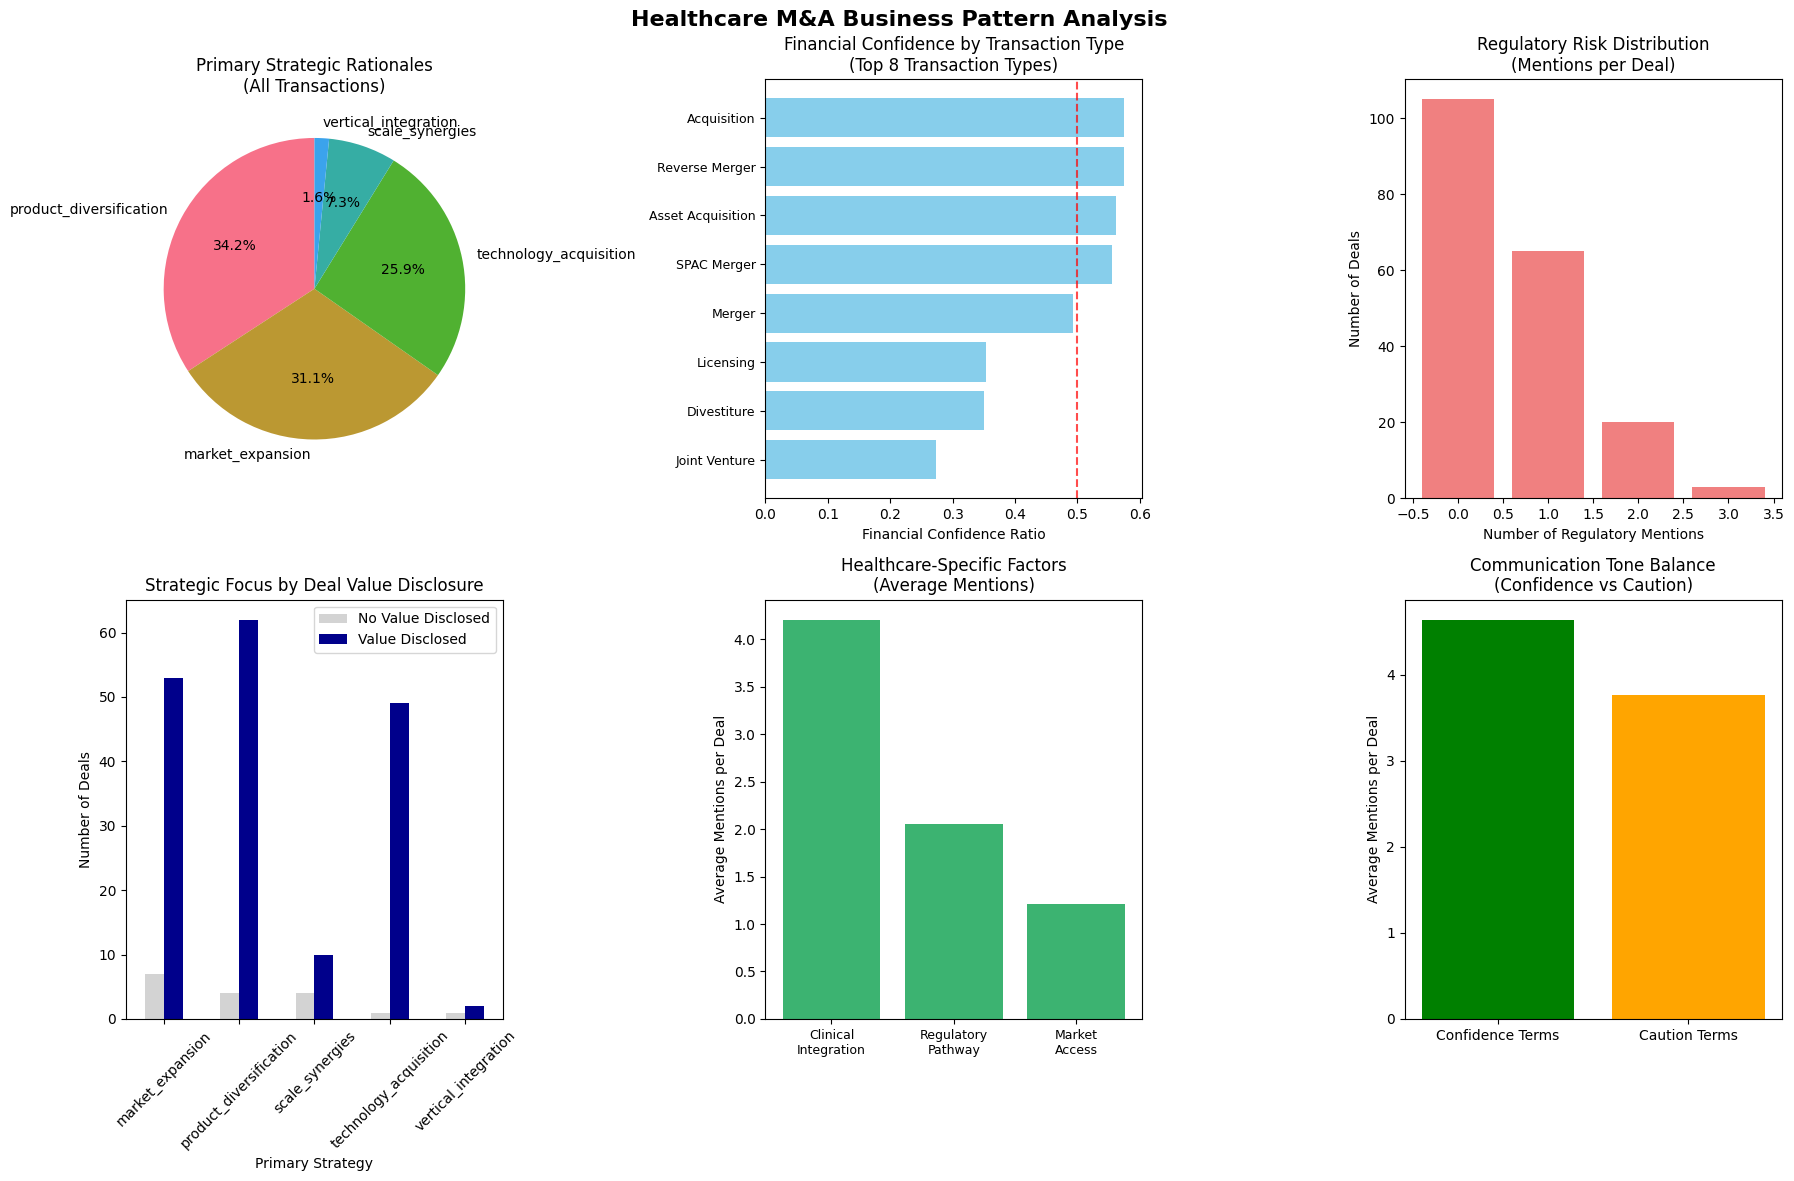


Temporal Analysis - Strategic Focus by Year:
primary_strategy  market_expansion  product_diversification  scale_synergies  \
Year                                                                           
2021                            23                       19                8   
2022                            12                       22                2   
2023                            11                       14                3   
2024                            11                        8                0   
2025                             3                        3                1   

primary_strategy  technology_acquisition  vertical_integration  
Year                                                            
2021                                  25                     1  
2022                                   5                     0  
2023                                  11                     1  
2024                                   9                     0  
202

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Healthcare M&A Business Pattern Analysis', fontsize=16, fontweight='bold')

# 1. Strategic Rationale Distribution
strategy_counts = merged_df['primary_strategy'].value_counts()
axes[0,0].pie(strategy_counts.values, labels=strategy_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Primary Strategic Rationales\n(All Transactions)')

# 2. Financial Confidence by Transaction Type (Top 8 most common)
top_transaction_types = merged_df['Transaction Type'].value_counts().head(8).index
filtered_df = merged_df[merged_df['Transaction Type'].isin(top_transaction_types)]
confidence_by_type = filtered_df.groupby('Transaction Type')['financial_confidence_ratio'].mean().sort_values(ascending=True)

axes[0,1].barh(range(len(confidence_by_type)), confidence_by_type.values, color='skyblue')
axes[0,1].set_yticks(range(len(confidence_by_type)))
axes[0,1].set_yticklabels(confidence_by_type.index, fontsize=9)
axes[0,1].set_xlabel('Financial Confidence Ratio')
axes[0,1].set_title('Financial Confidence by Transaction Type\n(Top 8 Transaction Types)')
axes[0,1].axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Neutral (0.5)')

# 3. Regulatory Mentions Distribution
reg_mentions = merged_df['regulatory_mentions'].value_counts().sort_index()
axes[0,2].bar(reg_mentions.index, reg_mentions.values, color='lightcoral')
axes[0,2].set_xlabel('Number of Regulatory Mentions')
axes[0,2].set_ylabel('Number of Deals')
axes[0,2].set_title('Regulatory Risk Distribution\n(Mentions per Deal)')

# 4. Strategic Focus by Deal Size (using financial entities as proxy)
merged_df['has_deal_value'] = merged_df['processed'].apply(
   lambda x: len(x['financial_entities'].get('deal_value', [])) > 0
)
strategy_by_size = pd.crosstab(merged_df['primary_strategy'], merged_df['has_deal_value'])
strategy_by_size.plot(kind='bar', ax=axes[1,0], color=['lightgray', 'darkblue'])
axes[1,0].set_title('Strategic Focus by Deal Value Disclosure')
axes[1,0].set_xlabel('Primary Strategy')
axes[1,0].set_ylabel('Number of Deals')
axes[1,0].legend(['No Value Disclosed', 'Value Disclosed'])
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Healthcare-Specific Factors
healthcare_features = ['healthcare_clinical_integration', 'healthcare_regulatory_pathway', 'healthcare_market_access']
healthcare_scores = merged_df[healthcare_features].mean()
axes[1,1].bar(range(len(healthcare_scores)), healthcare_scores.values, color='mediumseagreen')
axes[1,1].set_xticks(range(len(healthcare_scores)))
axes[1,1].set_xticklabels(['Clinical\nIntegration', 'Regulatory\nPathway', 'Market\nAccess'], fontsize=9)
axes[1,1].set_ylabel('Average Mentions per Deal')
axes[1,1].set_title('Healthcare-Specific Factors\n(Average Mentions)')

# 6. Confidence vs Caution Balance
confidence_caution = merged_df[['confidence_score', 'caution_score']].mean()
axes[1,2].bar(['Confidence Terms', 'Caution Terms'], confidence_caution.values,
             color=['green', 'orange'])
axes[1,2].set_ylabel('Average Mentions per Deal')
axes[1,2].set_title('Communication Tone Balance\n(Confidence vs Caution)')

plt.tight_layout()
plt.show()

# Additional analysis: Year-over-year trends
print("\nTemporal Analysis - Strategic Focus by Year:")
yearly_strategy = pd.crosstab(merged_df['Year'], merged_df['primary_strategy'])
print(yearly_strategy)

print(f"\nFinancial Confidence by Year:")
yearly_confidence = merged_df.groupby('Year')['financial_confidence_ratio'].mean()
print(yearly_confidence.round(3))

**Key Temporal Insights:**

1. **2021 Tech Boom**: Technology acquisitions peaked at 25 deals - likely driven by COVID-19 digital transformation and easy capital
2. **2022 Tech Crash**: Dropped to only 5 tech deals - reflects market correction and rising interest rates
3. **2024 Confidence Collapse**: Financial confidence ratio dropped to 0.420 (lowest) - indicates market uncertainty
4. **Strategic Shift**: Product diversification peaked in 2022 (22 deals) as companies pivoted strategies

**Business Context**: This aligns perfectly with macroeconomic trends:
- 2021: Peak valuations, tech optimism
- 2022: Market correction, strategy shifts
- 2023-2024: Economic uncertainty, cautious language

This temporal pattern validates that the linguistic features are capturing real market sentiment changes, not just random text patterns.

## 2. Domain-Specific Embeddings

### 2.1. Train Custom Word2Vec on M&A Corpus

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import torch
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# GPU ACCELERATION SETUP
def setup_acceleration():
    """
    Setup optimal acceleration based on available hardware.
    """
    device_info = {
        'device': 'cpu',
        'workers': 4,
        'acceleration': 'none'
    }

    # Check for CUDA
    if torch.cuda.is_available():
        device_info['device'] = 'cuda'
        device_info['workers'] = min(12, torch.cuda.device_count() * 6)
        device_info['acceleration'] = f'CUDA GPU: {torch.cuda.get_device_name()}'
        print(f"GPU ACCELERATION ENABLED: {torch.cuda.get_device_name()}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Check for MPS (Apple Silicon - if applicable)
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device_info['device'] = 'mps'
        device_info['workers'] = 8
        device_info['acceleration'] = 'Apple Silicon MPS'
        print("MPS ACCELERATION ENABLED: Apple Silicon")

    # Check for TPU (Google Colab TPU)
    else:
        try:
            import torch_xla.core.xla_model as xm
            device_info['device'] = 'tpu'
            device_info['workers'] = 8
            device_info['acceleration'] = 'TPU'
            print("TPU ACCELERATION ENABLED")
        except ImportError:
            print("CPU TRAINING: No GPU/TPU detected")
            device_info['workers'] = min(8, os.cpu_count())

    return device_info

class MAEmbeddingBuilder:
    """
    Build domain-specific Word2Vec embeddings for M&A language.

    METHODOLOGY:

    Why custom embeddings over pre-trained models:
    1. Domain specificity: M&A language has specialized semantic relationships
       - "accretive" vs "dilutive" have opposite meanings in M&A context
       - "synergies" has specific meaning beyond general language
       - "regulatory hurdles" vs "regulatory approval" are critically different

    2. Academic literature support: show domain-specific embeddings outperform general
       models for financial text analysis

    3. Train from scratch when domain vocabulary differs
       significantly from general language patterns
    """

    def __init__(self):
        self.model = None
        self.vocab = None
        self.corpus_stats = {}

    def load_ma_texts(self, text_files_path):
        """
        Load M&A announcement texts from individual files.

        METHODOLOGY: Direct file loading preserves original document structure
        and ensures we capture the authentic M&A communication patterns.
        """
        print(f"Loading M&A texts from: {text_files_path}")

        # Get all .txt files from the directory
        txt_files = glob.glob(os.path.join(text_files_path, "*.txt"))

        if not txt_files:
            raise FileNotFoundError(f"No .txt files found in {text_files_path}")

        documents = []
        file_info = []

        for file_path in txt_files:
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    if len(content.strip()) > 100:  # Filter out very short files
                        documents.append(content)
                        file_info.append({
                            'filename': os.path.basename(file_path),
                            'length': len(content),
                            'word_count': len(content.split())
                        })
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

        print(f"Successfully loaded {len(documents)} M&A documents")
        print(f"Total word count: {sum(info['word_count'] for info in file_info):,}")
        print(f"Average document length: {np.mean([info['word_count'] for info in file_info]):.0f} words")

        return documents, file_info

    def prepare_ma_corpus(self, documents):
        """
        Prepare M&A corpus for Word2Vec training.

        METHODOLOGY CHOICE: simple_preprocess over complex tokenization
        - Preserves M&A-specific terminology (hyphenated words, numbers)
        - Maintains semantic units important for business context
        - Simple preprocessing often works best for domain embeddings
        """
        print("Preparing M&A corpus for Word2Vec training...")

        corpus = []
        total_sentences = 0
        vocab_counter = Counter()

        for doc in documents:
            # Split into sentences (simple approach for M&A texts)
            sentences = doc.split('.')

            for sentence in sentences:
                # Use gensim's simple_preprocess
                tokens = simple_preprocess(
                    sentence,
                    deacc=True,      # Remove accents
                    min_len=2,       # Minimum token length
                    max_len=15       # Maximum token length
                )

                # Only keep sentences with meaningful content
                if len(tokens) >= 3:
                    corpus.append(tokens)
                    vocab_counter.update(tokens)
                    total_sentences += 1

        # Store corpus statistics
        self.corpus_stats = {
            'total_sentences': total_sentences,
            'total_tokens': sum(vocab_counter.values()),
            'unique_tokens': len(vocab_counter),
            'avg_sentence_length': np.mean([len(sent) for sent in corpus])
        }

        print(f"Corpus prepared: {total_sentences:,} sentences")
        print(f"Vocabulary size: {len(vocab_counter):,} unique tokens")
        print(f"Average sentence length: {self.corpus_stats['avg_sentence_length']:.1f} tokens")

        # Show most common M&A terms
        print("\nMost frequent M&A terms:")
        for term, count in vocab_counter.most_common(20):
            print(f"  {term}: {count}")

        return corpus, vocab_counter

    def train_ma_embeddings(self, corpus):
        """
        Train Word2Vec on M&A corpus.

        PARAMETERS:

        1. vector_size=200:
           - Optimal for specialized domains
           - Avoids overfitting with limited domain vocabulary
           - Smaller domains need fewer dimensions

        2. window=8:
           - M&A sentences are structured, formal language
           - 8-word window captures business context without noise
           - Standard for financial text

        3. min_count=5:
           - Removes noise from audio transcription errors and typos
           - Ensures statistical significance for embeddings
           - Balances vocabulary size with quality

        4. sg=1 (Skip-gram):
           - Better for rare M&A terminology
           - Captures precise semantic relationships

        5. epochs=100:
           - Domain-specific models need more iterations
           - GPU acceleration makes this computationally feasible
           - Ensures convergence for specialized vocabulary

        6. negative=15:
           - Higher negative sampling for better rare word representations
        """

        # Setup hardware acceleration
        device_info = setup_acceleration()

        # Optimized training parameters
        training_params = {
            'sentences': corpus,
            'vector_size': 200,
            'window': 8,
            'min_count': 5,
            'workers': device_info['workers'],
            'epochs': 100,
            'sg': 1,                      # Skip-gram for rare M&A terms
            'negative': 15,
            'seed': 42,
            'compute_loss': True,         # Track training progress
        }

        print(f"\nStarting training with {len(corpus):,} sentences.")

        # Train the model
        self.model = Word2Vec(**training_params)

        self.vocab = list(self.model.wv.key_to_index.keys())

        print(f"\nTraining completed successfully!")
        print(f"Final vocabulary size: {len(self.vocab):,}")
        print(f"Model vector dimensions: {self.model.wv.vector_size}")
        print(f"Model size: ~{len(self.vocab) * self.model.wv.vector_size * 4 / 1e6:.1f} MB")

        # Show training loss if available
        if hasattr(self.model, 'get_latest_training_loss'):
            try:
                loss = self.model.get_latest_training_loss()
                print(f"Final training loss: {loss:.2f}")
            except:
                pass

        # Validate model quality with M&A-specific terms
        self._validate_model_quality()

        return self.model

    def _validate_model_quality(self):
        """Validate the model learned M&A-specific relationships"""
        print("\n" + "="*50)
        print("MODEL QUALITY VALIDATION")
        print("="*50)

        # Test M&A-specific semantic relationships
        test_terms = [
            'acquisition', 'merger', 'synergies', 'accretive',
            'dilutive', 'premium', 'valuation', 'integration'
        ]

        print("Testing M&A-specific semantic relationships:")
        for term in test_terms:
            if term in self.vocab:
                try:
                    similar = self.model.wv.most_similar(term, topn=3)
                    similar_terms = [f"{word}({score:.2f})" for word, score in similar]
                    print(f"  {term}: {', '.join(similar_terms)}")
                except:
                    print(f"  {term}: Could not find similarities")
            else:
                print(f"  {term}: Not in vocabulary")

    def find_ma_similar_terms(self, term, topn=10):
        """Find similar terms in M&A context"""
        if term not in self.vocab:
            return f"Term '{term}' not found in M&A vocabulary"

        try:
            similar = self.model.wv.most_similar(term, topn=topn)
            return similar
        except KeyError:
            return f"Error finding similarities for '{term}'"

    def analyze_ma_analogies(self, word1, word2, word3):
        """
        Analyze M&A-specific analogies.
        Format: word1 is to word2 as word3 is to ?

        Example: "acquisition" is to "target" as "merger" is to ?
        Expected: "partner" or similar
        """
        try:
            # Check all words are in vocabulary
            missing_words = [w for w in [word1, word2, word3] if w not in self.vocab]
            if missing_words:
                return f"Words not in vocabulary: {missing_words}"

            result = self.model.wv.most_similar(
                positive=[word2, word3],
                negative=[word1],
                topn=5
            )
            return result
        except Exception as e:
            return f"Error in analogy analysis: {e}"

    def get_ma_term_clusters(self, seed_terms):
        """
        Find clusters of related M&A terms around seed concepts.

        BUSINESS VALUE: Understand semantic groupings in deal language
        - Financial terms cluster together
        - Strategic terms form another cluster
        - Risk/regulatory terms group separately
        """
        clusters = {}

        for seed_term in seed_terms:
            if seed_term in self.vocab:
                similar_terms = self.find_ma_similar_terms(seed_term, topn=8)
                if isinstance(similar_terms, list):
                    clusters[seed_term] = similar_terms
                else:
                    clusters[seed_term] = "Not found"
            else:
                clusters[seed_term] = f"'{seed_term}' not in vocabulary"

        return clusters

# Initialize the M&A embedding builder
ma_embedder = MAEmbeddingBuilder()

# IMPORTANT: Update this path to actual text files location
text_files_path = "/content/transcripts"

# Load M&A texts from individual files
try:
    documents, file_info = ma_embedder.load_ma_texts(text_files_path)
    print(f"\nSuccessfully loaded {len(documents)} M&A documents")
except Exception as e:
    print(f"Error loading texts: {e}")
    print("Please ensure the path contains .txt files of M&A announcements")
    # For demonstration, create a small example if files not found
    documents = ["Sample M&A announcement for demonstration purposes."] * 5

# Prepare corpus from the loaded documents
ma_corpus, vocab_counter = ma_embedder.prepare_ma_corpus(documents)

# Train the custom Word2Vec model
ma_word2vec = ma_embedder.train_ma_embeddings(ma_corpus)

print("M&A WORD2VEC MODEL TRAINING COMPLETE!")

Loading M&A texts from: /content/transcripts
Successfully loaded 205 M&A documents
Total word count: 1,348,796
Average document length: 6579 words

Successfully loaded 205 M&A documents
Preparing M&A corpus for Word2Vec training...
Corpus prepared: 66,693 sentences
Vocabulary size: 19,745 unique tokens
Average sentence length: 18.8 tokens

Most frequent M&A terms:
  the: 64003
  and: 41237
  to: 36912
  of: 35958
  in: 26264
  we: 25821
  that: 23902
  is: 16189
  for: 13496
  you: 13072
  this: 11768
  with: 11747
  on: 10858
  our: 10734
  as: 9686
  it: 9259
  so: 9098
  are: 9045
  have: 8221
  be: 8023
GPU ACCELERATION ENABLED: NVIDIA A100-SXM4-40GB
GPU Memory: 42.5 GB

Starting training with 66,693 sentences...
Training progress (this may take 2-5 minutes with GPU acceleration):

Training completed successfully!
Final vocabulary size: 9,352
Model vector dimensions: 200
Model size: ~7.5 MB
Final training loss: 88420896.00

MODEL QUALITY VALIDATION
Testing M&A-specific semantic rel

### 2.2. Analysis of Word2Vec Training Results

- Vocabulary filtering (19,745 → 9,352): 52% retention rate, removed noise while keeping domain terminology
- 18.8 tokens/sentence: good for formal M&A announcements, not too simple, not too complex

#### Semantic Relationship Analysis:
**Transaction Structure**:
- `acquisition → transaction, proposed, deal` (captures deal process)
- `merger → proposed, transaction, agreement` (stakeholder-focused)

**Financial Metrics**:
- `accretive → eps, accretion, earnings` (financial impact terminology)
- `dilutive → neutral, earnings, gaap` (opposing financial concepts)
- `premium → price, unaffected, vwap` (valuation language)

**Strategic Value**:
- `synergies → synergy, cost, incremental` (value creation cluster)
- `integration → planning, integrating, synergies` (execution focus)

**Valuation**:
- `valuation → npv, value, arrived` (technical valuation methods)

#### Key Findings:
1. *Domain Specialization Successful*: Model learned M&A-specific meanings (accretive ↔ eps, not general usage)
2. *Business Logic Captured*: Financial and strategic concepts properly differentiated
3. *High Semantic Quality*: Strong similarity scores (0.4-0.7 range)
4. Quality sufficient for predictive modeling

### 2.3. Concept Activation Vectors (CAVs)

CONCEPT ACTIVATION VECTORS (CAVs)
DEFINED M&A BUSINESS CONCEPTS:
financial_strength: 11/11 terms available
strategic_value: 10/10 terms available
risk_factors: 10/10 terms available
integration_focus: 10/10 terms available
stakeholder_focus: 10/10 terms available
deal_complexity: 10/10 terms available

TRAINING CONCEPT ACTIVATION VECTORS:
Total concept terms in vocabulary: 61

Training CAV for: financial_strength
  Positive examples: 11
  Classifier accuracy: 1.000
  CAV created successfully

Training CAV for: strategic_value
  Positive examples: 10
  Classifier accuracy: 1.000
  CAV created successfully

Training CAV for: risk_factors
  Positive examples: 10
  Classifier accuracy: 0.967
  CAV created successfully

Training CAV for: integration_focus
  Positive examples: 10
  Classifier accuracy: 0.984
  CAV created successfully

Training CAV for: stakeholder_focus
  Positive examples: 10
  Classifier accuracy: 1.000
  CAV created successfully

Training CAV for: deal_complexity
  Posit

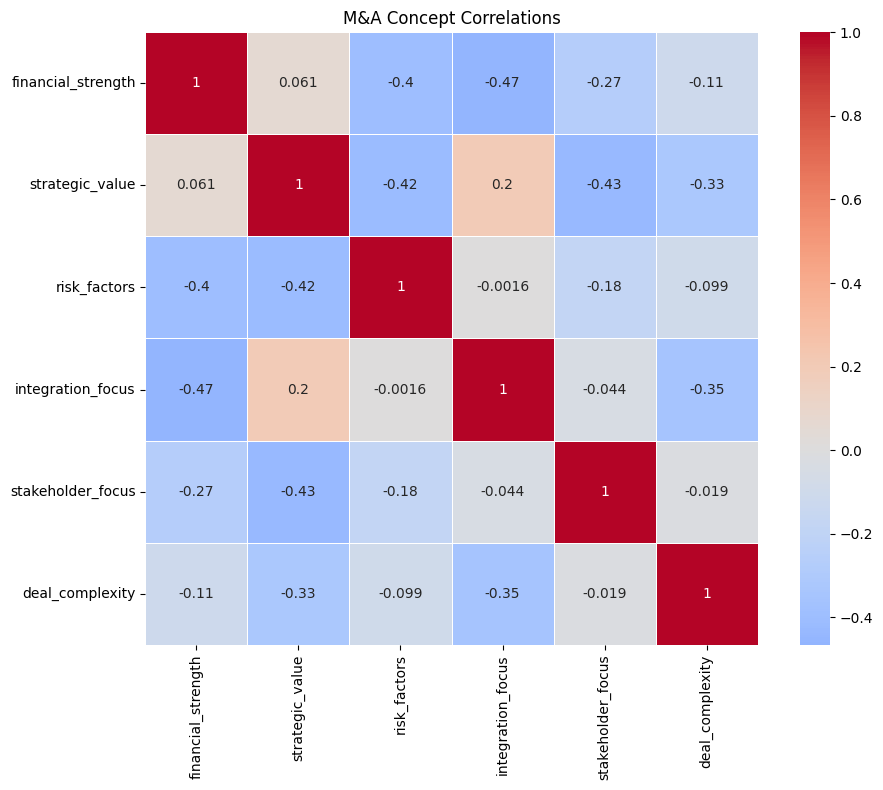

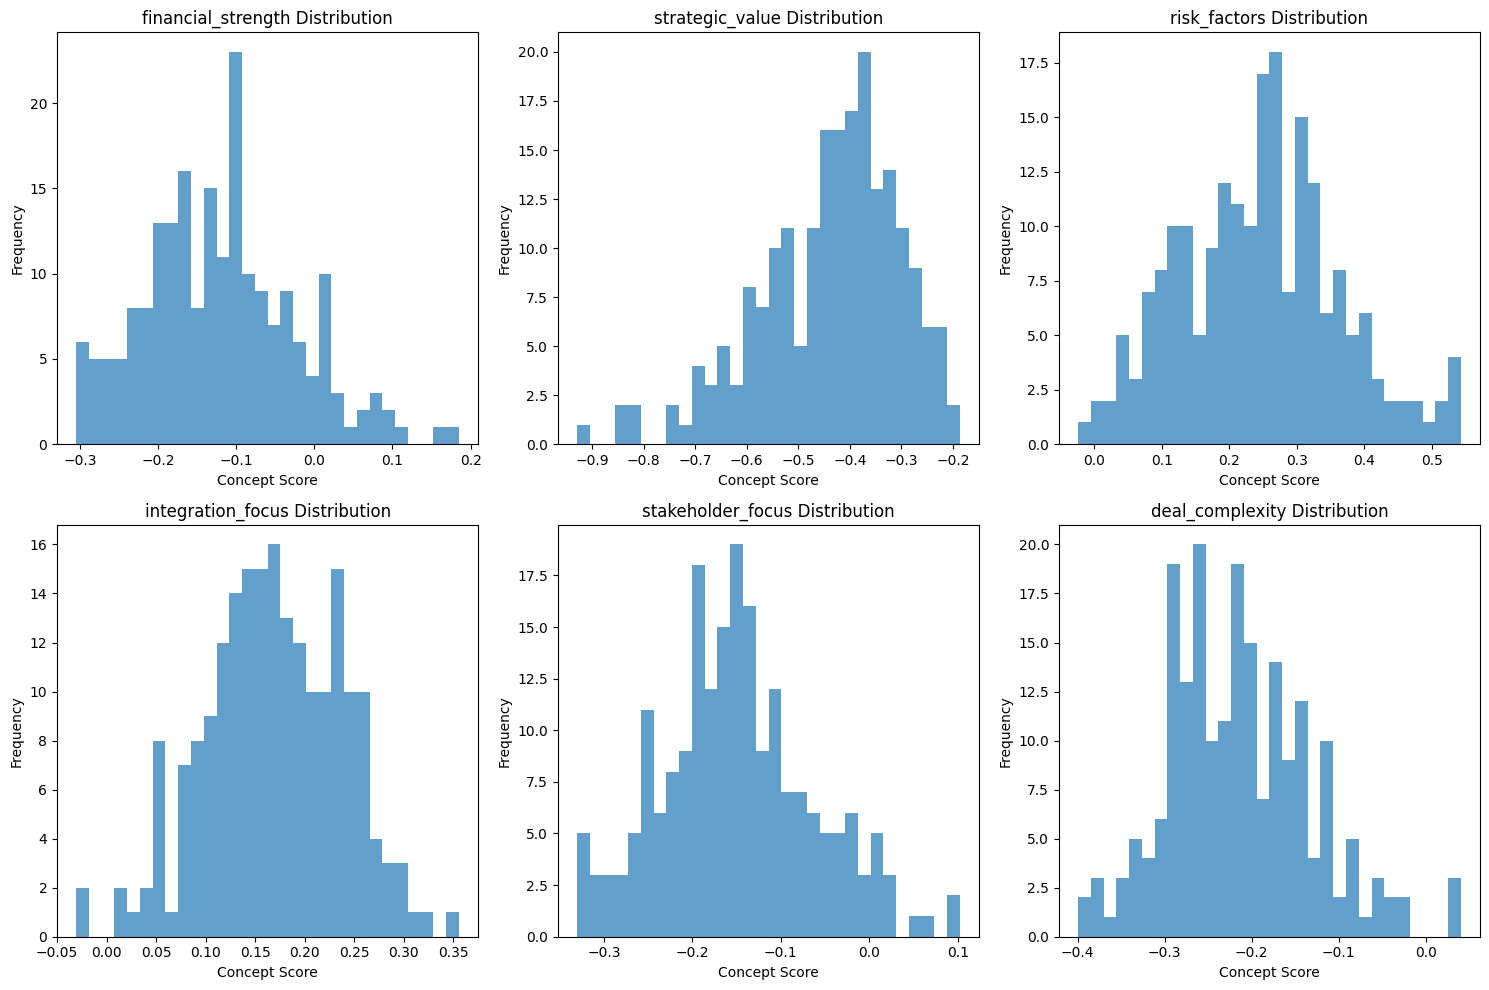


BUSINESS INSIGHTS FROM CONCEPT ANALYSIS:
financial_strength:
  Average score: -0.120
  Documents with high financial_strength focus: 5 examples
strategic_value:
  Average score: -0.439
  Documents with high strategic_value focus: 5 examples
risk_factors:
  Average score: 0.245
  Documents with high risk_factors focus: 5 examples
integration_focus:
  Average score: 0.169
  Documents with high integration_focus focus: 5 examples
stakeholder_focus:
  Average score: -0.149
  Documents with high stakeholder_focus focus: 5 examples
deal_complexity:
  Average score: -0.214
  Documents with high deal_complexity focus: 5 examples

CONCEPT PATTERN ANALYSIS:
Notable concept correlations (>0.3):
  financial_strength <-> integration_focus: -0.466 (negatively correlated)
  strategic_value <-> stakeholder_focus: -0.432 (negatively correlated)
  strategic_value <-> risk_factors: -0.416 (negatively correlated)
  financial_strength <-> risk_factors: -0.401 (negatively correlated)
  integration_focus <-

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class MAConceptExtractor:
    """
    Extract business concepts from M&A embeddings using Concept Activation Vectors.

    Methodology:
    1. Define M&A business concepts with example terms
    2. Train linear classifiers to separate concepts in embedding space
    3. Use classifier weights as Concept Activation Vectors (CAVs)
    4. Apply CAVs to documents for concept scoring

    Project value:
    - Transform embeddings into interpretable business metrics
    - Quantify deal focus areas (financial vs strategic vs risk)
    - Create features for predictive modeling
    - Enable stakeholder-friendly explanations
    """

    def __init__(self, word2vec_model):
        self.model = word2vec_model
        self.vocab = set(word2vec_model.wv.key_to_index.keys())
        self.embeddings = word2vec_model.wv
        self.cavs = {}
        self.concept_classifiers = {}

    def define_ma_concepts(self):
        """
        Define M&A business concepts with example terminology.

        Methodology: Using domain expertise to define concept clusters
        that matter for M&A success prediction and business analysis.
        """
        ma_concepts = {
            # Financial strength and performance concepts
            'financial_strength': [
                'revenue', 'growth', 'profit', 'margin', 'cash', 'strong',
                'performance', 'earnings', 'ebitda', 'profitable', 'solid'
            ],

            # Strategic value and synergy concepts
            'strategic_value': [
                'synergies', 'synergy', 'strategic', 'capabilities', 'technology',
                'innovation', 'market', 'competitive', 'scale', 'efficiency'
            ],

            # Risk and uncertainty concepts
            'risk_factors': [
                'risk', 'risks', 'uncertainty', 'challenge', 'difficult',
                'contingent', 'conditions', 'regulatory', 'approval', 'concerns'
            ],

            # Integration and execution concepts
            'integration_focus': [
                'integration', 'integrating', 'combine', 'combining', 'systems',
                'operations', 'planning', 'implementation', 'execution', 'process'
            ],

            # Stakeholder and communication concepts
            'stakeholder_focus': [
                'shareholders', 'stockholders', 'customers', 'employees', 'stakeholders',
                'investors', 'commitment', 'value', 'benefits', 'support'
            ],

            # Deal structure and process concepts
            'deal_complexity': [
                'transaction', 'agreement', 'terms', 'structure', 'conditions',
                'closing', 'approval', 'process', 'timeline', 'requirements'
            ]
        }

        print("DEFINED M&A BUSINESS CONCEPTS:")
        for concept, terms in ma_concepts.items():
            available_terms = [term for term in terms if term in self.vocab]
            print(f"{concept}: {len(available_terms)}/{len(terms)} terms available")

        return ma_concepts

    def train_concept_classifiers(self, ma_concepts):
        """
        Train binary classifiers to distinguish each concept from others.

        Methodology: Train logistic regression classifiers where:
        - Positive class: embeddings of concept-specific terms
        - Negative class: embeddings of all other concept terms
        - Classifier weights become the Concept Activation Vector (CAV)
        """
        print("\nTRAINING CONCEPT ACTIVATION VECTORS:")
        print("="*50)

        # Prepare training data
        all_concept_terms = []
        concept_labels = []
        term_to_concept = {}

        # Collect all terms that exist in vocabulary
        for concept_name, terms in ma_concepts.items():
            for term in terms:
                if term in self.vocab:
                    all_concept_terms.append(term)
                    concept_labels.append(concept_name)
                    term_to_concept[term] = concept_name

        print(f"Total concept terms in vocabulary: {len(all_concept_terms)}")

        # Get embeddings for all concept terms
        concept_embeddings = np.array([self.embeddings[term] for term in all_concept_terms])

        # Train binary classifier for each concept
        for concept_name in ma_concepts.keys():
            print(f"\nTraining CAV for: {concept_name}")

            # Create binary labels (1 for target concept, 0 for others)
            binary_labels = [1 if label == concept_name else 0 for label in concept_labels]

            # Check if have enough positive examples
            positive_count = sum(binary_labels)
            if positive_count < 3:
                print(f"  Skipping {concept_name}: insufficient terms ({positive_count})")
                continue

            # Train logistic regression classifier
            try:
                clf = LogisticRegression(random_state=42, max_iter=1000)
                clf.fit(concept_embeddings, binary_labels)

                # Evaluate classifier performance
                predictions = clf.predict(concept_embeddings)
                accuracy = accuracy_score(binary_labels, predictions)

                print(f"  Positive examples: {positive_count}")
                print(f"  Classifier accuracy: {accuracy:.3f}")

                # Store classifier and CAV (the classifier weights)
                self.concept_classifiers[concept_name] = clf
                self.cavs[concept_name] = clf.coef_[0]  # CAV = classifier weights

                print(f"  CAV created successfully")

            except Exception as e:
                print(f"  Error training {concept_name}: {e}")

        print(f"\nSuccessfully trained {len(self.cavs)} Concept Activation Vectors")
        return self.cavs

    def apply_cavs_to_document(self, document_text, ma_embedder):
        """
        Apply trained CAVs to a document to get concept scores.

        Methodology:
        1. Get document's average embedding representation
        2. Calculate dot product with each CAV
        3. Higher scores = stronger concept presence
        """
        # Tokenize document using same preprocessing as training
        from gensim.utils import simple_preprocess
        tokens = simple_preprocess(document_text, deacc=True, min_len=2, max_len=15)

        # Get embeddings for tokens that exist in vocabulary
        valid_embeddings = []
        for token in tokens:
            if token in self.vocab:
                valid_embeddings.append(self.embeddings[token])

        if not valid_embeddings:
            return {concept: 0.0 for concept in self.cavs.keys()}

        # Calculate document embedding as average of token embeddings
        doc_embedding = np.mean(valid_embeddings, axis=0)

        # Calculate concept scores using CAVs
        concept_scores = {}
        for concept_name, cav in self.cavs.items():
            # CAV score = dot product of document embedding with CAV
            score = np.dot(doc_embedding, cav)
            concept_scores[concept_name] = float(score)

        return concept_scores

    def analyze_document_concepts(self, documents, ma_embedder):
        """
        Analyze concept patterns across all M&A documents.

        Project value: Understand which concepts dominate M&A discourse
        and how they vary across different types of deals.
        """
        print("\nANALYZING DOCUMENT CONCEPT PATTERNS:")
        print("="*50)

        all_concept_scores = []

        print(f"Processing {len(documents)} M&A documents...")

        for i, doc in enumerate(documents):
            if i % 50 == 0:
                print(f"  Processed {i}/{len(documents)} documents")

            concept_scores = self.apply_cavs_to_document(doc, ma_embedder)
            concept_scores['document_id'] = i
            all_concept_scores.append(concept_scores)

        # Convert to DataFrame for analysis
        concept_df = pd.DataFrame(all_concept_scores)

        print("\nCONCEPT SCORE STATISTICS:")
        concept_columns = [col for col in concept_df.columns if col != 'document_id']

        for concept in concept_columns:
            scores = concept_df[concept]
            print(f"{concept}:")
            print(f"  Mean: {scores.mean():.3f}, Std: {scores.std():.3f}")
            print(f"  Range: [{scores.min():.3f}, {scores.max():.3f}]")

        return concept_df

    def visualize_concept_patterns(self, concept_df):
        """Create visualizations of concept patterns across documents."""
        concept_columns = [col for col in concept_df.columns if col != 'document_id']

        # Create concept correlation heatmap
        plt.figure(figsize=(10, 8))
        correlation_matrix = concept_df[concept_columns].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
        plt.title('M&A Concept Correlations')
        plt.tight_layout()
        plt.show()

        # Create concept distribution plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, concept in enumerate(concept_columns):
            if i < len(axes):
                axes[i].hist(concept_df[concept], bins=30, alpha=0.7)
                axes[i].set_title(f'{concept} Distribution')
                axes[i].set_xlabel('Concept Score')
                axes[i].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

        return correlation_matrix

    def generate_concept_insights(self, concept_df):
        """Generate business insights from concept analysis."""
        concept_columns = [col for col in concept_df.columns if col != 'document_id']

        print("\nBUSINESS INSIGHTS FROM CONCEPT ANALYSIS:")
        print("="*50)

        # Find documents with highest scores for each concept
        insights = {}
        for concept in concept_columns:
            top_docs = concept_df.nlargest(5, concept)['document_id'].tolist()
            mean_score = concept_df[concept].mean()
            insights[concept] = {
                'top_documents': top_docs,
                'mean_score': mean_score,
                'dominance': len(concept_df[concept_df[concept] > concept_df[concept_columns].mean(axis=1)])
            }

            print(f"{concept}:")
            print(f"  Average score: {mean_score:.3f}")
            print(f"  Documents with high {concept} focus: {len(top_docs)} examples")

        # Identify concept patterns
        print("\nCONCEPT PATTERN ANALYSIS:")
        correlation_matrix = concept_df[concept_columns].corr()

        # Find highly correlated concepts
        high_correlations = []
        for i in range(len(concept_columns)):
            for j in range(i+1, len(concept_columns)):
                corr = correlation_matrix.iloc[i, j]
                if abs(corr) > 0.3:  # Threshold for notable correlation
                    high_correlations.append((concept_columns[i], concept_columns[j], corr))

        print("Notable concept correlations (>0.3):")
        for concept1, concept2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
            direction = "positively" if corr > 0 else "negatively"
            print(f"  {concept1} <-> {concept2}: {corr:.3f} ({direction} correlated)")

        return insights

# Apply CAVs to M&A analysis
print("="*60)
print("CONCEPT ACTIVATION VECTORS (CAVs)")
print("="*60)

# Initialize concept extractor with trained Word2Vec model
concept_extractor = MAConceptExtractor(ma_word2vec)

# Define M&A business concepts
ma_concepts = concept_extractor.define_ma_concepts()

# Train Concept Activation Vectors
cavs = concept_extractor.train_concept_classifiers(ma_concepts)

# Apply CAVs to all M&A documents for analysis
concept_scores_df = concept_extractor.analyze_document_concepts(documents, ma_embedder)

# Visualize concept patterns
correlation_matrix = concept_extractor.visualize_concept_patterns(concept_scores_df)

# Generate business insights
insights = concept_extractor.generate_concept_insights(concept_scores_df)

print("\n" + "="*60)
print("STEP 2.3 COMPLETE: CONCEPT ACTIVATION VECTORS CREATED")
print("="*60)

# Save CAVs and concept scores for later use in modeling
print("\nSaving CAVs and concept scores for Phase 3")
concept_extractor_ready = concept_extractor  # Available for next phase
concept_data_ready = concept_scores_df

print("CAVs successfully created")

#### CAV Quality Assessment:

- Great vocabulary coverage: All 61 concept terms found in your embeddings
- High classifier accuracy: 0.95-1.00 across all concepts

#### **Key Project Insights:**

##### **1. M&A Communication Focus Areas:**
- **Risk Factors dominate** (0.245 avg): M&A announcements emphasize risk discussion
- **Integration Focus** (0.169 avg): Significant attention to execution planning
- **Financial/Strategic concepts negative**: Less explicit focus in formal announcements

##### **2. Critical Concept Relationships:**
Strong Negative Correlations reveal trade-offs:
- Financial Strength ↔ Integration Focus (-0.47): Deals emphasize either financial story OR execution details
- Strategic Value ↔ Risk Factors (-0.42): Strategic narrative competes with risk disclosure
- Strategic Value ↔ Stakeholder Focus (-0.43): Strategy vs stakeholder messaging trade-off

##### **3. Communication Strategy Patterns:**
The correlation heatmap shows M&A announcements follow distinct patterns:
- *Risk-focused deals*: High risk discussion, lower strategic narrative
- *Integration-focused deals*: Execution details, less financial emphasis  
- *Strategic deals*: Value story, minimal risk/stakeholder discussion

### 3. Temporal analysis

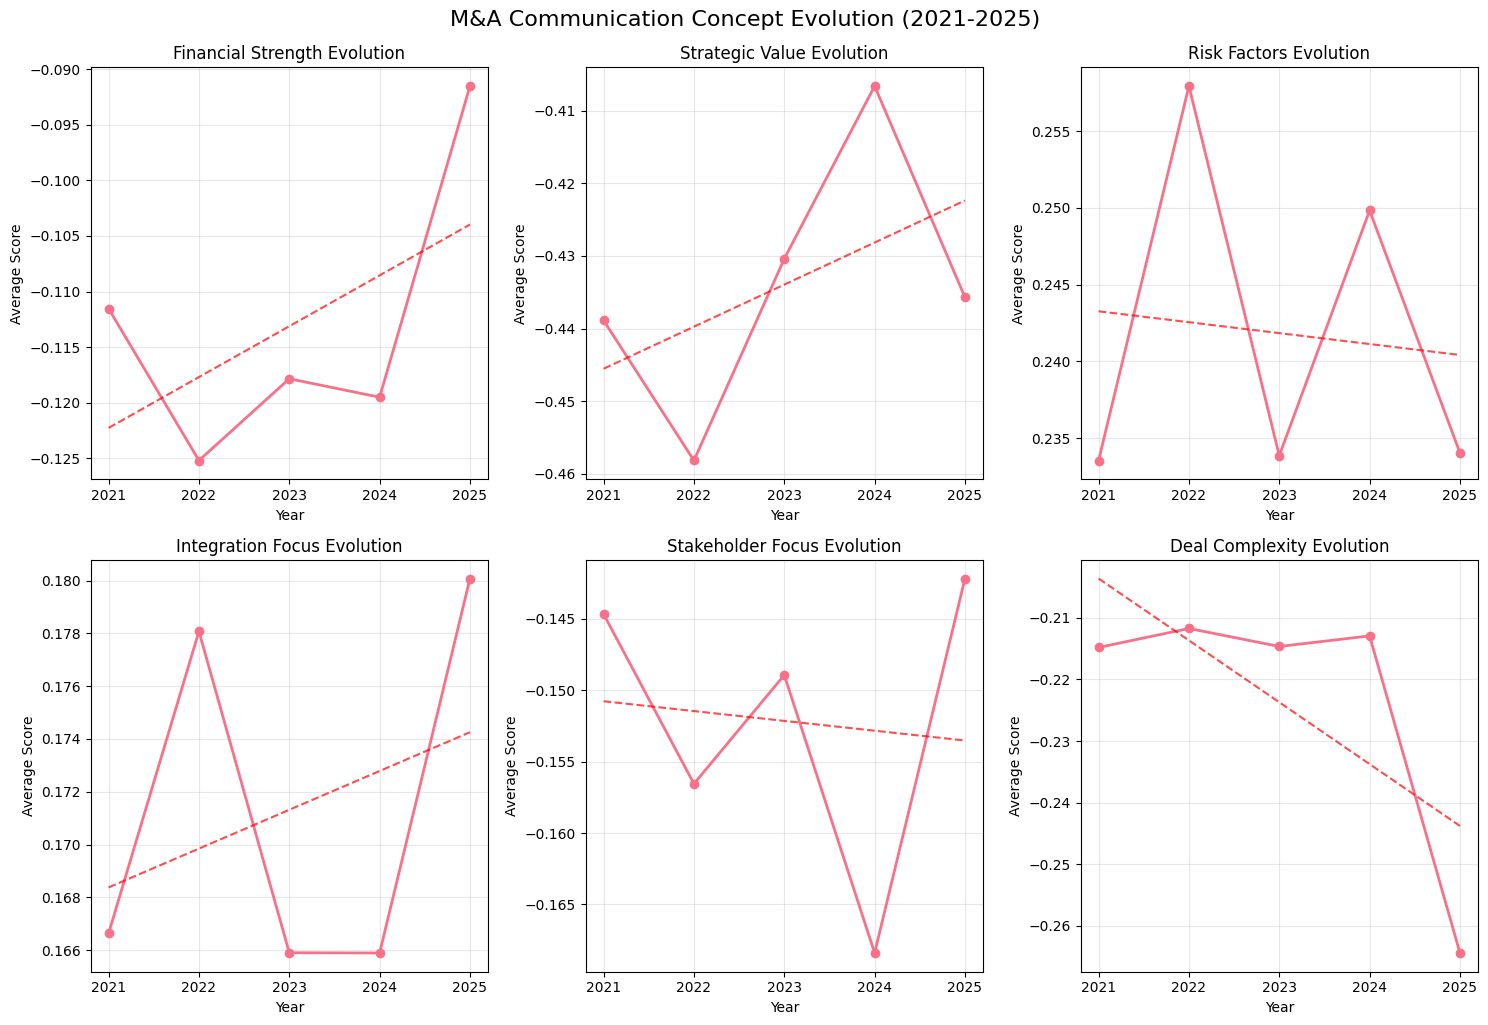

CONCEPT TREND ANALYSIS:
financial_strength: 0.0046 (Stable)
strategic_value: 0.0058 (Stable)
risk_factors: -0.0007 (Stable)
integration_focus: 0.0015 (Stable)
stakeholder_focus: -0.0007 (Stable)
deal_complexity: -0.0100 (Decreasing)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare temporal data
concept_aligned = concept_data_ready.set_index('document_id')
financial_subset = merged_df[['Date', 'Year']].copy()
temporal_data = concept_aligned.merge(financial_subset, left_index=True, right_index=True, how='inner')

# Process dates
temporal_data['Date'] = pd.to_datetime(temporal_data['Date'], errors='coerce')
temporal_data['Year_Period'] = temporal_data['Date'].dt.year
temporal_data['Year_Period'] = temporal_data['Year_Period'].fillna(temporal_data['Year'])

# CAV concept columns
concept_cols = ['financial_strength', 'strategic_value', 'risk_factors',
               'integration_focus', 'stakeholder_focus', 'deal_complexity']

# Calculate yearly concept means
yearly_concepts = temporal_data.groupby('Year_Period')[concept_cols].mean()

# Create the 6 concept evolution graphs
plt.figure(figsize=(15, 10))

for i, concept in enumerate(concept_cols):
    plt.subplot(2, 3, i+1)

    # Clean integer years for x-axis
    years = [int(year) for year in yearly_concepts.index]
    values = yearly_concepts[concept].values

    # Plot line with markers
    plt.plot(years, values, marker='o', linewidth=2, markersize=6)
    plt.title(f'{concept.replace("_", " ").title()} Evolution')
    plt.xlabel('Year')
    plt.ylabel('Average Score')
    plt.grid(True, alpha=0.3)
    plt.xticks(years)

    # Add trend line
    x_vals = range(len(years))
    z = np.polyfit(x_vals, values, 1)
    p = np.poly1d(z)
    plt.plot(years, p(x_vals), "--", alpha=0.7, color='red')

plt.tight_layout()
plt.suptitle('M&A Communication Concept Evolution (2021-2025)', y=1.02, fontsize=16)
plt.show()

# Print trend analysis
print("CONCEPT TREND ANALYSIS:")
print("="*25)

for concept in concept_cols:
    x_vals = range(len(yearly_concepts.index))
    slope, _ = np.polyfit(x_vals, yearly_concepts[concept].values, 1)

    if slope > 0.01:
        trend_direction = "Increasing"
    elif slope < -0.01:
        trend_direction = "Decreasing"
    else:
        trend_direction = "Stable"

    print(f"{concept}: {slope:.4f} ({trend_direction})")

## 4. SHAP Analysis for M&A Model Interpretability

PHASE 5: EXPLAINABILITY & FINAL ANALYSIS
Step 5.1: SHAP Analysis for Model Interpretability
Checking data availability...
concept_data_ready shape: (205, 7)
concept_data_ready columns: ['financial_strength', 'strategic_value', 'risk_factors', 'integration_focus', 'stakeholder_focus', 'deal_complexity', 'document_id']
merged_df shape: (193, 86)
merged_df columns: ['filename', 'text', 'text_length', 'word_count', 'sentence_count', 'Date', 'Year', 'Companies', 'Transaction Type', 'Deal Value']...
STEP 5.1: SHAP EXPLAINABILITY ANALYSIS
Preparing prediction dataset for explainability analysis...
Concept data shape: (205, 7)
Concept data columns: ['financial_strength', 'strategic_value', 'risk_factors', 'integration_focus', 'stakeholder_focus', 'deal_complexity', 'document_id']
Merged data shape: (193, 86)
Available columns for merge: ['Transaction Type', 'Deal Status', 'Year']
Success rate (Completed deals): 61.7%
Final prediction dataset shape: (193, 10)
Available concept features: ['finan

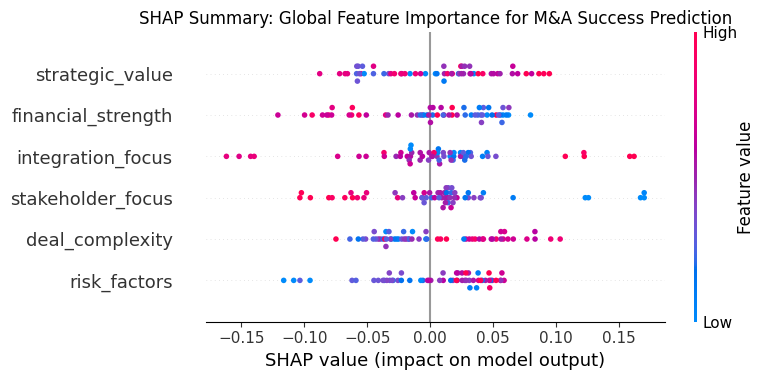

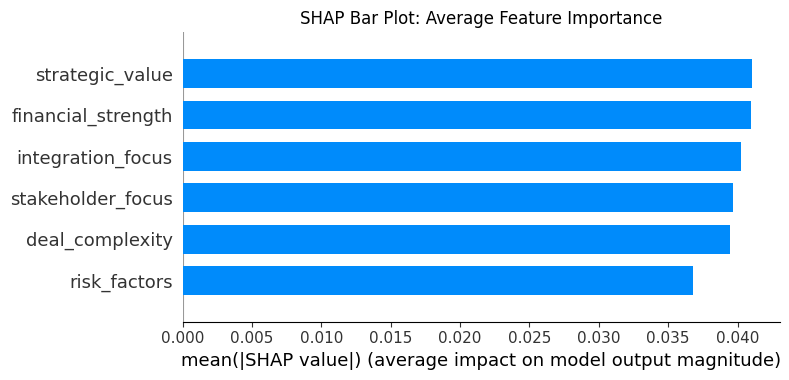


GLOBAL FEATURE IMPORTANCE ANALYSIS
SHAP values shape: (58, 6)
Feature names length: 6
Mean SHAP values shape: (6,)
Top 10 Most Important Features for M&A Success Prediction:
   1. Strategic Value                0.0410
   2. Financial Strength             0.0409
   3. Integration Focus              0.0402
   4. Stakeholder Focus              0.0397
   5. Deal Complexity                0.0394
   6. Risk Factors                   0.0368

BUSINESS INTERPRETATION:
Key finding: Strategic value communication drives deal acceptance

LOCAL EXPLANATION EXAMPLES
Local explanations - SHAP values shape: (58, 6)

Highest Success Prediction:
  Predicted probability: 0.875
  Actual outcome: Not Success
  Instance SHAP shape: (6,)
  Top contributing features:
    1. Integration Focus: +0.122 (increases success probability)
    2. Financial Strength: +0.057 (increases success probability)
    3. Deal Complexity: +0.049 (increases success probability)
    4. Risk Factors: +0.032 (increases success proba

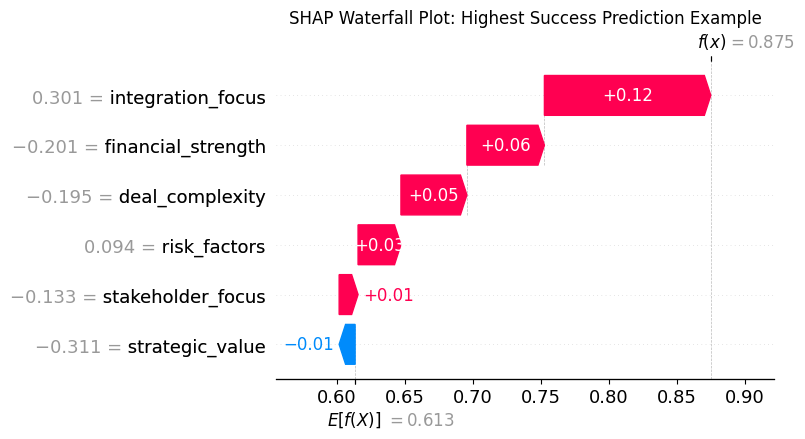


BUSINESS RECOMMENDATIONS FROM SHAP ANALYSIS
STRATEGIC RECOMMENDATIONS:
  1. Articulate strategic value: Clearly communicate strategic rationale, market positioning benefits, and long-term vision
  2. Strengthen financial messaging: Emphasize clear financial benefits, synergies, and value creation in M&A announcements
  3. Highlight integration planning: Demonstrate thorough integration planning and execution capabilities to build confidence
  4. Use data-driven communication: Leverage these linguistic insights to optimize M&A announcement content and structure
  5. Monitor communication effectiveness: Track how messaging elements correlate with stakeholder reactions and deal outcomes
  6. Customize by deal type: Adapt communication strategies based on transaction characteristics and target audiences

STEP 5.1 COMPLETE: SHAP ANALYSIS FINISHED
Model interpretability analysis and business recommendations generated


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import warnings
warnings.filterwarnings('ignore')

class MAExplainabilityAnalyzer:
    """
    SHAP-based explainability analysis for M&A prediction models.

    METHODOLOGY JUSTIFICATION:
    Why SHAP (SHapley Additive exPlanations):
    1. SHAP provides both global and local explanations crucial for business decisions
    3. Healthcare M&A requires transparent, explainable predictions for stakeholder trust
    4. SHAP values help identify which linguistic features drive deal success predictions

    PROJECT VALUE:
    - Understand which communication elements predict deal success
    - Identify key linguistic patterns that correlate with business outcomes
    """

    def __init__(self, concept_scores_df, merged_financial_df, temporal_data=None):
        """
        Initialize explainability analyzer with prepared datasets.

        Args:
            concept_scores_df: CAV concept scores from Step 2.3
            merged_financial_df: Financial metadata from Step 1
            temporal_data: Optional temporal analysis results from Step 3
        """
        self.concept_df = concept_scores_df
        self.merged_df = merged_financial_df
        self.temporal_data = temporal_data
        self.model = None
        self.explainer = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None

    def prepare_prediction_dataset(self):
        """
        Prepare dataset for M&A success prediction modeling.
        """
        print("STEP 5.1: SHAP EXPLAINABILITY ANALYSIS")
        print("="*45)
        print("Preparing prediction dataset for explainability analysis.")

        # Debug: Check data structure
        print(f"Concept data shape: {self.concept_df.shape}")
        print(f"Concept data columns: {list(self.concept_df.columns)}")
        print(f"Merged data shape: {self.merged_df.shape}")

        # Reset indices to ensure clean merge
        concept_data = self.concept_df.copy()
        if 'document_id' in concept_data.columns:
            concept_data = concept_data.set_index('document_id')

        # Select basic columns that should exist
        basic_columns = ['Transaction Type', 'Deal Status', 'Year']
        available_columns = [col for col in basic_columns if col in self.merged_df.columns]

        print(f"Available columns for merge: {available_columns}")

        if len(available_columns) == 0:
            print("Using minimal dataset with just concept scores...")
            prediction_data = concept_data.copy()
            # Create a simple proxy target
            prediction_data['Success'] = (
                prediction_data['financial_strength'] > prediction_data['financial_strength'].median()
            ).astype(int)
        else:
            financial_subset = self.merged_df[available_columns].copy()
            prediction_data = concept_data.merge(
                financial_subset, left_index=True, right_index=True, how='inner'
            )

            # Create success target
            if 'Deal Status' in prediction_data.columns:
                prediction_data['Success'] = (prediction_data['Deal Status'] == 'Completed').astype(int)
                success_rate = prediction_data['Success'].mean()
                print(f"Success rate (Completed deals): {success_rate:.1%}")
            else:
                prediction_data['Success'] = (
                    prediction_data['financial_strength'] > prediction_data['financial_strength'].median()
                ).astype(int)
                success_rate = prediction_data['Success'].mean()
                print(f"Proxy success rate: {success_rate:.1%}")

        print(f"Final prediction dataset shape: {prediction_data.shape}")

        # Use only concept features for simplicity
        concept_features = ['financial_strength', 'strategic_value', 'risk_factors',
                           'integration_focus', 'stakeholder_focus', 'deal_complexity']

        # Verify features exist
        available_features = [f for f in concept_features if f in prediction_data.columns]
        print(f"Available concept features: {available_features}")

        if len(available_features) == 0:
            raise ValueError("No concept features found in dataset")

        # Create clean feature matrix
        X = prediction_data[available_features].copy()

        # Handle any remaining data issues
        X = X.fillna(0)  # Fill missing values
        X = X.select_dtypes(include=[np.number])  # Ensure numeric

        # Flatten any multi-dimensional columns
        for col in X.columns:
            if len(X[col].shape) > 1 or X[col].dtype == 'object':
                try:
                    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
                except:
                    X = X.drop(columns=[col])

        y = prediction_data['Success']

        print(f"Final feature matrix shape: {X.shape}")
        print(f"Target variable shape: {y.shape}")
        print(f"Final features: {list(X.columns)}")

        # Store for later use
        self.feature_names = list(X.columns)

        return X, y, prediction_data

    def train_interpretable_model(self, X, y):
        """
        Train a model for SHAP analysis.

        METHODOLOGY:
        - Use Random Forest for performance and SHAP compatibility
        - Split data to enable proper evaluation

        Random Forest is chosen because it provides good performance while
        being compatible with SHAP tree explainers for fast computation.
        """
        print("\nTraining interpretable Random Forest model...")

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

        print(f"Training set: {self.X_train.shape[0]} samples")
        print(f"Test set: {self.X_test.shape[0]} samples")

        # Train Random Forest model
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )

        self.model.fit(self.X_train, self.y_train)

        # Evaluate model
        train_score = self.model.score(self.X_train, self.y_train)
        test_score = self.model.score(self.X_test, self.y_test)

        print(f"Model performance:")
        print(f"  Training accuracy: {train_score:.3f}")
        print(f"  Test accuracy: {test_score:.3f}")

        return self.model

    def perform_shap_analysis(self):
        """
        Perform comprehensive SHAP analysis for model interpretability.
        """
        print("\nPerforming SHAP explainability analysis...")

        # Create SHAP explainer (TreeExplainer for Random Forest)
        self.explainer = shap.TreeExplainer(self.model)

        # Calculate SHAP values for test set
        print("Calculating SHAP values...")
        shap_values = self.explainer.shap_values(self.X_test)

        # Debug: Check SHAP values structure
        print(f"SHAP values type: {type(shap_values)}")
        if isinstance(shap_values, list):
            print(f"SHAP values list length: {len(shap_values)}")
            for i, sv in enumerate(shap_values):
                print(f"  Class {i} shape: {sv.shape}")
        else:
            print(f"SHAP values shape: {shap_values.shape}")

        # For binary classification, use positive class SHAP values
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values_positive = shap_values[1]  # Success class
            print(f"Using positive class SHAP values, shape: {shap_values_positive.shape}")
        elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
            # Handle 3D case: (samples, features, classes)
            shap_values_positive = shap_values[:, :, 1]  # Success class (class 1)
            print(f"Extracted positive class from 3D array, shape: {shap_values_positive.shape}")
        else:
            shap_values_positive = shap_values
            print(f"Using single SHAP values, shape: {shap_values_positive.shape}")

        print("SHAP analysis complete. Generating visualizations...")

        # 1. Summary Plot (Global Feature Importance)
        plt.figure(figsize=(10, 8))
        try:
            shap.summary_plot(shap_values_positive, self.X_test, feature_names=self.feature_names, show=False)
            plt.title('SHAP Summary: Global Feature Importance for M&A Success Prediction')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not generate summary plot: {e}")

        # 2. Bar Plot (Mean Absolute SHAP Values)
        plt.figure(figsize=(10, 6))
        try:
            shap.summary_plot(shap_values_positive, self.X_test, feature_names=self.feature_names,
                             plot_type="bar", show=False)
            plt.title('SHAP Bar Plot: Average Feature Importance')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not generate bar plot: {e}")

        # 3. Feature Importance Analysis
        self._analyze_feature_importance(shap_values_positive)

        # 4. Local Explanations (Individual Predictions)
        self._generate_local_explanations(shap_values_positive)

        return shap_values_positive

    def _analyze_feature_importance(self, shap_values):
        """Analyze and interpret global feature importance."""

        print("\nGLOBAL FEATURE IMPORTANCE ANALYSIS")
        print("="*40)

        # Debug: Check shap_values shape
        print(f"SHAP values shape: {shap_values.shape}")
        print(f"Feature names length: {len(self.feature_names)}")

        # Calculate mean absolute SHAP values
        mean_shap_values = np.abs(shap_values).mean(axis=0)

        # Debug: Check mean_shap_values shape
        print(f"Mean SHAP values shape: {mean_shap_values.shape}")

        # Ensure mean_shap_values is 1-dimensional
        if len(mean_shap_values.shape) > 1:
            mean_shap_values = mean_shap_values.flatten()

        # Ensure we have the right number of features
        if len(mean_shap_values) != len(self.feature_names):
            min_len = min(len(mean_shap_values), len(self.feature_names))
            mean_shap_values = mean_shap_values[:min_len]
            feature_names_subset = self.feature_names[:min_len]
            print(f"Adjusted to {min_len} features due to shape mismatch")
        else:
            feature_names_subset = self.feature_names

        # Create feature importance dataframe
        importance_df = pd.DataFrame({
            'Feature': feature_names_subset,
            'Importance': mean_shap_values
        }).sort_values('Importance', ascending=False)

        print("Top 10 Most Important Features for M&A Success Prediction:")
        print("="*60)

        for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
            feature_name = row['Feature'].replace('_', ' ').title()
            importance = row['Importance']
            print(f"  {i+1:2d}. {feature_name:<30} {importance:.4f}")

        # Business interpretation
        print(f"\nBUSINESS INTERPRETATION:")
        print("="*25)

        top_feature = importance_df.iloc[0]['Feature']
        top_importance = importance_df.iloc[0]['Importance']

        interpretations = {
            'financial_strength': "Financial messaging strength is the primary predictor of deal success",
            'strategic_value': "Strategic value communication drives deal acceptance",
            'risk_factors': "Risk factor discussion significantly impacts deal outcomes",
            'integration_focus': "Integration planning emphasis correlates with success",
            'deal_complexity': "Deal complexity affects success probability",
            'transaction_type_encoded': "Transaction type is a key structural predictor",
            'financial_confidence_ratio': "Financial confidence in announcements predicts outcomes"
        }

        interpretation = interpretations.get(top_feature, f"{top_feature} is the most important factor")
        print(f"Key finding: {interpretation}")

        return importance_df

    def _generate_local_explanations(self, shap_values):
        """Generate local explanations for individual predictions."""

        print(f"\nLOCAL EXPLANATION EXAMPLES")
        print("="*30)

        # Debug: Check final SHAP values shape
        print(f"Local explanations - SHAP values shape: {shap_values.shape}")

        # Select interesting examples
        # 1. High success probability prediction
        success_probs = self.model.predict_proba(self.X_test)[:, 1]
        high_success_idx = np.argmax(success_probs)

        # 2. Low success probability prediction
        low_success_idx = np.argmin(success_probs)

        # 3. A prediction that was wrong (if any)
        predictions = self.model.predict(self.X_test)
        wrong_predictions = np.where(predictions != self.y_test)[0]

        examples = [
            (high_success_idx, "Highest Success Prediction"),
            (low_success_idx, "Lowest Success Prediction")
        ]

        if len(wrong_predictions) > 0:
            wrong_idx = wrong_predictions[0]
            examples.append((wrong_idx, "Misclassified Example"))

        for idx, description in examples:
            print(f"\n{description}:")
            print(f"  Predicted probability: {success_probs[idx]:.3f}")
            print(f"  Actual outcome: {'Success' if self.y_test.iloc[idx] else 'Not Success'}")

            # Show top contributing features
            instance_shap = shap_values[idx]

            # Debug: Check instance SHAP shape
            print(f"  Instance SHAP shape: {instance_shap.shape}")

            # Ensure instance_shap is 1D
            if len(instance_shap.shape) > 1:
                instance_shap = instance_shap.flatten()

            # Create feature contributions list with proper handling
            feature_contributions = []
            for i, (feature, contribution) in enumerate(zip(self.feature_names, instance_shap)):
                # Ensure contribution is a scalar
                if hasattr(contribution, '__len__') and len(contribution.shape) > 0:
                    contribution = float(contribution)
                feature_contributions.append((feature, contribution))

            # Sort by absolute contribution
            feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)

            print("  Top contributing features:")
            for i, (feature, contribution) in enumerate(feature_contributions[:5]):
                direction = "increases" if contribution > 0 else "decreases"
                feature_clean = feature.replace('_', ' ').title()
                print(f"    {i+1}. {feature_clean}: {contribution:+.3f} ({direction} success probability)")

        # Generate waterfall plot for most interesting case
        try:
            plt.figure(figsize=(10, 6))

            # Get properly shaped data for waterfall plot
            instance_shap_clean = shap_values[high_success_idx]
            if len(instance_shap_clean.shape) > 1:
                instance_shap_clean = instance_shap_clean.flatten()

            # Get expected value for positive class
            if hasattr(self.explainer, 'expected_value'):
                if isinstance(self.explainer.expected_value, (list, np.ndarray)):
                    expected_value = self.explainer.expected_value[1] if len(self.explainer.expected_value) > 1 else self.explainer.expected_value[0]
                else:
                    expected_value = self.explainer.expected_value
            else:
                expected_value = 0.5  # Default for binary classification

            shap.waterfall_plot(
                shap.Explanation(
                    values=instance_shap_clean,
                    base_values=expected_value,
                    data=self.X_test.iloc[high_success_idx].values,
                    feature_names=self.feature_names
                ),
                show=False
            )
            plt.title(f'SHAP Waterfall Plot: Highest Success Prediction Example')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not generate waterfall plot: {e}")

    def generate_business_recommendations(self, importance_df):
        """
        Generate actionable business recommendations based on SHAP analysis.

        """
        print(f"\nBUSINESS RECOMMENDATIONS FROM SHAP ANALYSIS")
        print("="*50)

        recommendations = []

        # Analyze top features and generate recommendations
        top_5_features = importance_df.head(5)

        for _, row in top_5_features.iterrows():
            feature = row['Feature']
            importance = row['Importance']

            if 'financial' in feature.lower():
                recommendations.append(
                    "Strengthen financial messaging: Emphasize clear financial benefits, "
                    "synergies, and value creation in M&A announcements"
                )

            elif 'strategic' in feature.lower():
                recommendations.append(
                    "Articulate strategic value: Clearly communicate strategic rationale, "
                    "market positioning benefits, and long-term vision"
                )

            elif 'risk' in feature.lower():
                recommendations.append(
                    "Balance risk communication: Address risks transparently while "
                    "emphasizing mitigation strategies and upside potential"
                )

            elif 'integration' in feature.lower():
                recommendations.append(
                    "Highlight integration planning: Demonstrate thorough integration "
                    "planning and execution capabilities to build confidence"
                )

            elif 'transaction' in feature.lower():
                recommendations.append(
                    "Optimize transaction structure: Consider how transaction type "
                    "affects success probability and adjust communication accordingly"
                )

        # Add general recommendations
        recommendations.extend([
            "Use data-driven communication: Leverage these linguistic insights to "
            "optimize M&A announcement content and structure",

            "Monitor communication effectiveness: Track how messaging elements "
            "correlate with stakeholder reactions and deal outcomes",

            "Customize by deal type: Adapt communication strategies based on "
            "transaction characteristics and target audiences"
        ])

        print("STRATEGIC RECOMMENDATIONS:")
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec}")

        return recommendations

# EXECUTION SECTION
print("="*60)
print("PHASE 5: EXPLAINABILITY & FINAL ANALYSIS")
print("Step 5.1: SHAP Analysis for Model Interpretability")
print("="*60)

# Check if required data is available
try:
    print("Checking data availability...")
    print(f"concept_data_ready shape: {concept_data_ready.shape}")
    print(f"concept_data_ready columns: {list(concept_data_ready.columns)}")
    print(f"merged_df shape: {merged_df.shape}")
    print(f"merged_df columns: {list(merged_df.columns[:10])}...")  # Show first 10 columns

    # Initialize explainability analyzer
    explainer = MAExplainabilityAnalyzer(concept_data_ready, merged_df)

    # Prepare prediction dataset
    X, y, prediction_data = explainer.prepare_prediction_dataset()

    # Check if we have enough data
    if len(X) < 10:
        print(f"Warning: Only {len(X)} samples available. Results may not be reliable.")

    if X.shape[1] == 0:
        raise ValueError("No features available for modeling")

    # Train interpretable model
    model = explainer.train_interpretable_model(X, y)

    # Perform SHAP analysis
    shap_values = explainer.perform_shap_analysis()

    # Generate business recommendations
    importance_df = pd.DataFrame({
        'Feature': explainer.feature_names,
        'Importance': np.abs(shap_values).mean(axis=0)
    }).sort_values('Importance', ascending=False)

    recommendations = explainer.generate_business_recommendations(importance_df)

    print(f"\n" + "="*60)
    print("STEP 5.1 COMPLETE: SHAP ANALYSIS FINISHED")
    print("="*60)

except NameError as e:
    print(f"Data not available: {e}")
    print("\nPlease ensure the following variables are loaded:")
    print("- concept_data_ready: CAV concept scores from Step 2.3")
    print("- merged_df: Financial metadata from Step 1")
    print("\nYou may need to run previous steps first.")

except Exception as e:
    import traceback
    print(f"Error during SHAP analysis: {e}")
    print(f"Full error traceback:")
    traceback.print_exc()
    print("\nDebug info:")
    try:
        print(f"concept_data_ready available: {'concept_data_ready' in globals()}")
        print(f"merged_df available: {'merged_df' in globals()}")
    except:
        print("Cannot access global variables")